# <span style="background-color: yellow"> Group Project: How are an employee's distance from home to work and job involvement associated with the likelihood of their attrition?

Members: Jennifer Li, Allan Wang, Zihua Li, Emma Oh

# <span style="background-color: yellow"> I. Introduction

### Commute time and attrition
Have you ever considered skipping work—or even quitting—due to a long commute? Bakker and Demerouti's (2007) Job Demands-Resources Model suggests that prolonged commutes drain energy, reducing recovery time and job satisfaction. Zhang et al. (2023) supported this idea with an empirical study, showing that longer commutes are significantly linked to lower job satisfaction (β=.0024, p<.01).
### Job involvement and attrition
Despite commute time being an external obstacle, what motivates us to continue working? According to Self-Determination Theory (SDT), vocational satisfaction arises from meeting needs for competence and autonomy. Competence is the perceived ability to master work tasks, while autonomy involves the freedom to make meaningful decisions (Olafsen et al., 2017). Haivas et al. (2013) found that satisfying these needs through job engagement significantly reduces the intention to quit (β=-.56, p=.012 for autonomy; β=-.54, p=.016 for competence), suggesting that increased job involvement is linked to a lower intention to quit.

### Research Question
In line with previous research, our project seeks to investigate the inferential research question:
#### <span style="background-color: lightpink"> “How are an employee's distance from home to work and job involvement associated with the likelihood of their attrition?”

# <span style="background-color: yellow"> II. Methods and Results

# <span style="background-color: lightblue"> A. Exploratory data analysis

### <span style="background-color: lightgreen">1. Load libraries

In [27]:
# Load necessary libraries
library(tidyverse)
library(dplyr)
library(repr)
library(readr)
library(MASS)
library(infer)
library(gridExtra)
library(glmnet)
library(modelr)
library(car)
library(conflicted)
library(broom)
library(caret)

        
# Troubleshooting the masking problem w packages
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")
conflict_prefer("select", "dplyr")
conflict_prefer("combine", "gridExtra")

[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::lag over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::select over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer gridExtra::combine over any other package.


### <span style="background-color: lightgreen"> 2. Load dataset

In [28]:
url <- "https://raw.githubusercontent.com/jenniferjunyi0812/stat301proj/main/HR-Employee-Attrition%205.csv"
HR_data <- read_csv(url)

cat("Figure 1. Preview of the raw HR employee attrition dataset.\n")

head(HR_data, 3)

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Figure 1. Preview of the raw HR employee attrition dataset.


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0


### <span style="background-color: lightgreen"> 3. Clean dataset

In [29]:
# Main developer: Allan 
# Contributor: Jennifer

HR_clean <- HR_data %>%
        select(Attrition, DistanceFromHome, JobInvolvement) %>%
        mutate(Attrition = factor(Attrition, levels = c("No", "Yes")), 
               JobInvolvement = factor(JobInvolvement, levels = c(1, 2, 3, 4)),
               DistanceFromHome = as.numeric(DistanceFromHome)) |>
        na.omit()

cat("Figure 2. Preview of HR employee attrition dataset in a tidy format for visualizations.\n\n")
head(HR_clean, 3)
dim(HR_clean)

Figure 2. Preview of HR employee attrition dataset in a tidy format for visualizations.



Attrition,DistanceFromHome,JobInvolvement
<fct>,<dbl>,<fct>
Yes,1,3
No,8,2
Yes,2,2


[1] 1470    3

### <span style="background-color: lightgreen"> 4. Plot the relevant variables

Figure 3. Frequency of Attrition by Job Involvement.


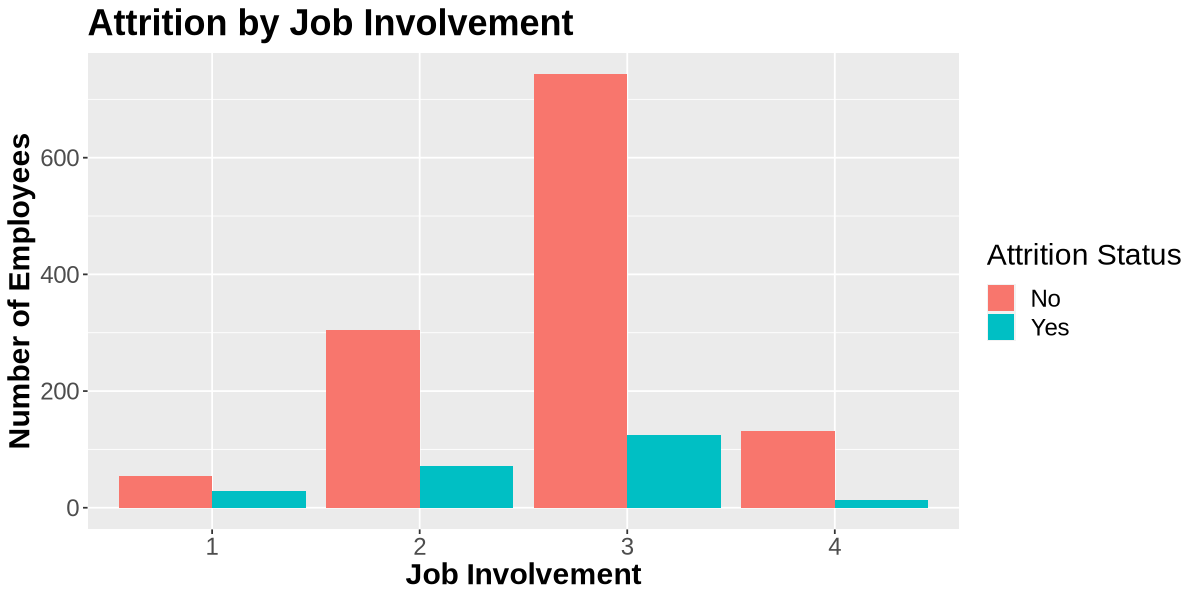

In [30]:
# Main developer: Jennifer
# Contributor: Allan (matched theme with other plots)
options(repr.plot.width = 10, repr.plot.height = 5)

bar_plot_involvement <- 
    HR_clean |>
    ggplot(aes(x = JobInvolvement, fill = Attrition)) +
    geom_bar(position = "dodge") +
    labs(
    title = "Attrition by Job Involvement",
    x = "Job Involvement",
    y = "Number of Employees",
    fill = "Attrition Status") +
    theme(
     text = element_text(size = 18),
     plot.title = element_text(face = "bold"),
     axis.title = element_text(face = "bold")
    )
bar_plot_involvement 
cat("Figure 3. Frequency of Attrition by Job Involvement.\n")

#### Observations
The bar plot and the contingency table show that employees with low job involvement have the highest attrition:non-attrition ratio (28:55). Further, as job involvement level increases, the ratio decreases (71:304, 125:743, 13:131, for medium, high, and very high respectively).

Figure 4. Box plot of employee's distance from home by their attrition status.


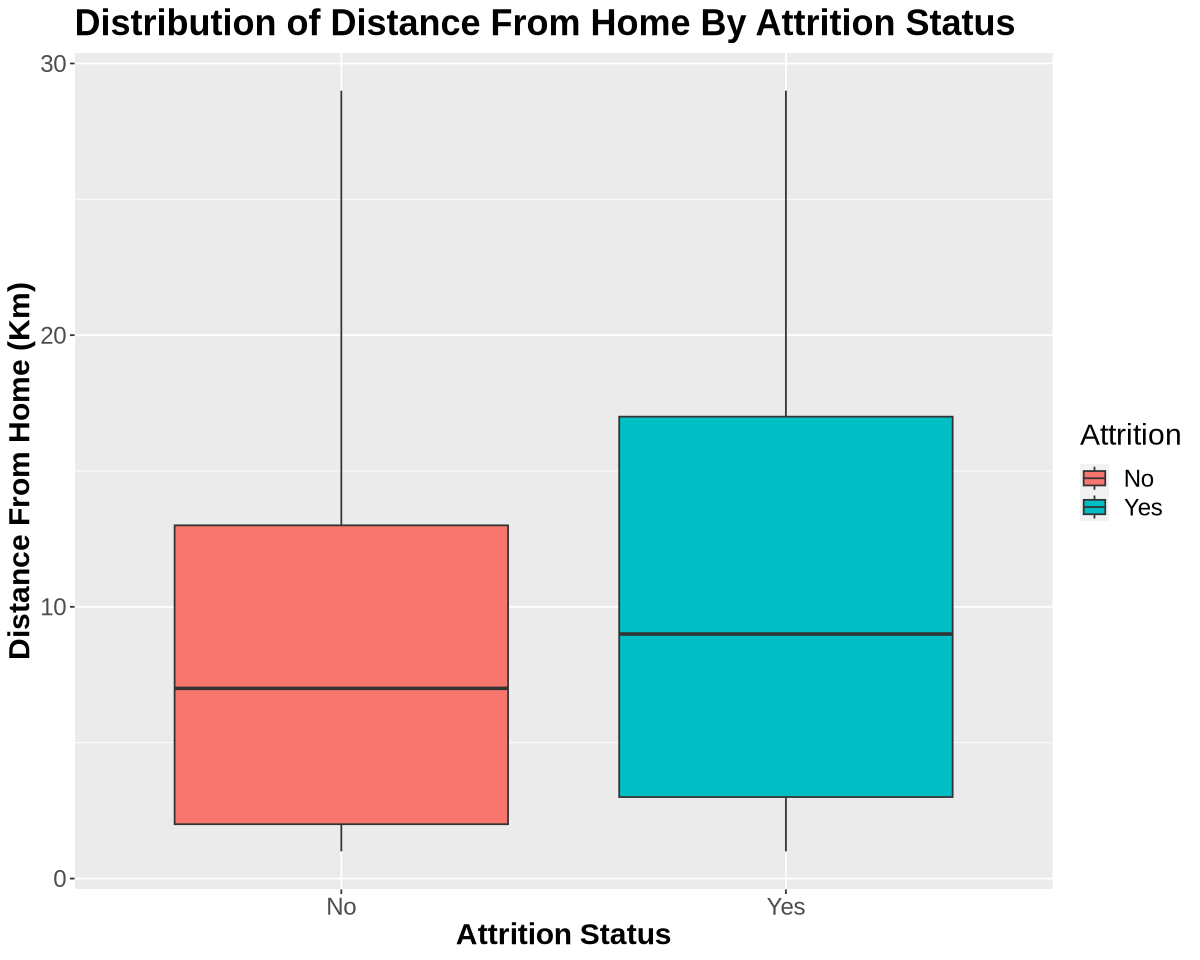

In [31]:
# Box plot of employee's distance from home by their attrition status
# Main developer: Allan

options(repr.plot.width = 10, repr.plot.height = 8)

dist_attrition_box <- HR_clean %>%
    ggplot() + 
    geom_boxplot(aes(x = Attrition, y = DistanceFromHome, fill = Attrition)) +
    labs(x = "Attrition Status",
         y = "Distance From Home (Km)") +
    ggtitle("Distribution of Distance From Home By Attrition Status") +
    theme(
     text = element_text(size = 18),
     plot.title = element_text(face = "bold"),
     axis.title = element_text(face = "bold")
    )
cat("Figure 4. Box plot of employee's distance from home by their attrition status.\n")
dist_attrition_box


#### Observations
The box plot shows that employees who left tend to live farther from work compared to those who stayed, suggesting that living farther from work might be linked to higher attrition.

In [32]:
# Main developer: Allan
# Contributor: Jennifer

summary_involvement_attrition <- 
    HR_clean %>%
    select(-DistanceFromHome) %>%
    group_by(JobInvolvement, Attrition) %>%
    summarize(frequency = n(), .groups = "keep") %>%
    pivot_wider(names_from = Attrition, values_from = frequency, values_fill = list(frequency = 0))

colnames(summary_involvement_attrition) <- c("Job Involvement Level", "No Attrition", "Yes Attrition")

cat("Figure 5. Contingency table showing the frequency of employee job involvement levels by attrition status.\n\n")
summary_involvement_attrition

Figure 5. Contingency table showing the frequency of employee job involvement levels by attrition status.



Job Involvement Level,No Attrition,Yes Attrition
<fct>,<int>,<int>
1,55,28
2,304,71
3,743,125
4,131,13


# <span style="background-color: lightblue"> B. Methods: Plan

### <span style="background-color: lightgreen"> 1. Feature selection

#### <span style="background-color: pink"> What are our variables?
**Response Variable:** Attrition (whether an employee has left the company)

**Explanatory Variables:**
- **JobInvolvement**: Measure of employee involvement at work
    - 1 = Low, 2 = medium, 3 = high, 4 = very high
- **DistanceFromHome**: Distance in kilometers from home to office.

#### <span style="background-color: pink"> Why did we select our variables

**Job Involvement:** We chose Job Involvement as a measure of autonomy in SDT as it provides insights into the level of autonomy an employee experiences at work without being too broad like Job Satisfaction, which might include factors (e.g., coworker relationships) not of interest.

**Distance From Home:** We chose Distance From Home because longer commutes may lead to employee burnout (e.g., being stuck in rush hour).

#### <span style="background-color: pink"> Forward stepwise regression

Before selecting Job Involvement and Distance From Home as our predictors, we used stepwise forward selection to ensure their significance. For a variable to be considered a quality predictor, it should have a significant p-value ($\alpha < 0.05$) in the model.


In [35]:
# performing stepwise forward regression 
#Main developer: Jennifer
#Contributor: Emma

# remove constant variables (2)
HR_data_remove <- HR_data |>
   select(-Over18, -EmployeeCount)

# verify the columns have been removed (32 variables)
print(colnames(HR_data_remove))

# convert relevant columns to appropriate data types
hr_clean_2 <- HR_data_remove %>%
  mutate(Attrition = factor(Attrition),
         JobInvolvement = factor(JobInvolvement, levels = c(1, 2, 3, 4)),
         OverTime = factor(OverTime, levels = c("No", "Yes")),
         Education = as.factor(Education),
         Department = as.factor(Department),
         JobRole = as.factor(JobRole),
         MaritalStatus = as.factor(MaritalStatus),
         BusinessTravel = as.factor(BusinessTravel))

# perform forward selection using stepAIC w goal of finding significant predictors
base_model <- glm(Attrition ~ 1, data = hr_clean_2, family = binomial)
full_model <- glm(Attrition ~ ., data = hr_clean_2, family = binomial)
forward_model <- stepAIC(base_model, direction = "forward", scope = list(lower = base_model, upper = full_model), trace = FALSE)

# summary of the final selected model
summary(forward_model)

 [1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "DailyRate"               
 [5] "Department"               "DistanceFromHome"        
 [7] "Education"                "EducationField"          
 [9] "EmployeeNumber"           "EnvironmentSatisfaction" 
[11] "Gender"                   "HourlyRate"              
[13] "JobInvolvement"           "JobLevel"                
[15] "JobRole"                  "JobSatisfaction"         
[17] "MaritalStatus"            "MonthlyIncome"           
[19] "MonthlyRate"              "NumCompaniesWorked"      
[21] "OverTime"                 "PercentSalaryHike"       
[23] "PerformanceRating"        "RelationshipSatisfaction"
[25] "StandardHours"            "StockOptionLevel"        
[27] "TotalWorkingYears"        "TrainingTimesLastYear"   
[29] "WorkLifeBalance"          "YearsAtCompany"          
[31] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[33] "YearsWithCurrManager"    



Call:
glm(formula = Attrition ~ OverTime + JobRole + MaritalStatus + 
    EnvironmentSatisfaction + JobSatisfaction + JobInvolvement + 
    BusinessTravel + YearsInCurrentRole + YearsSinceLastPromotion + 
    DistanceFromHome + NumCompaniesWorked + Age + WorkLifeBalance + 
    RelationshipSatisfaction + TrainingTimesLastYear + YearsWithCurrManager + 
    Gender + EducationField + TotalWorkingYears + YearsAtCompany + 
    StockOptionLevel, family = binomial, data = hr_clean_2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6456  -0.4899  -0.2542  -0.0925   3.3958  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.79413    1.17355   1.529 0.126315    
OverTimeYes                      1.96928    0.19275  10.217  < 2e-16 ***
JobRoleHuman Resources           1.33408    0.65879   2.025 0.042864 *  
JobRoleLaboratory Technician     1.53080    0.43854   3.491 0.000482 ***
JobRoleManager          

#### Observations
The final model with the lowest AIC included **Job Involvement** and **Distance From Home**, confirming their relevance as predictors of attrition with p-values \(< 0.05\).

### <span style="background-color: lightgreen"> 2. What method did we choose?

### <span style="background-color: lightpink"> Method: Logistic Regression:
To address how employee engagement (measured by JobInvolvement) and DistanceFromHome impact the likelihood of employees leaving the company, we use logistic regression as our analysis method. Logistic regression is suitable for this study because it handles a binary response variable and provides easily interpretable results.

**Log Odds Form:**
$$\log\left(\frac{p}{1-p}\right) = \beta_0  + \beta_1X_{DistanceFromHome} + \beta_2X_{JobInvolvement2} + \beta_3X_{JobInvolvement3} + \beta_4X_{JobInvolvement4}$$

### <span style="background-color: lightgreen"> 3. Fitting the Model

We fit the model to the `hr_clean` dataset using the glm function with family="binomial" to perform logistic regression. The coefficients are exponentiated, allowing interpretation as odds ratios.

**Job Involvement - Dummy Variables**

The categorical predictor `JobInvolvement` measures employee engagement on a scale of 1-4. Dummy variables are created, with level 1 as the reference. Our model includes three dummy variables:

\begin{equation}
 JobInvolvement_i =
   \left\{\begin{array}{lr}
       1, & \text{if  JobInvolvement}=i\\
       0, & \text{otherwise}
    \end{array}\right.
 \end{equation} 
 
  \begin{equation} 
  \text{for}\quad i = 2,3,4
   \end{equation}
 
Thus, we build the logistic regression model below. 

In [20]:
#Developer: Emma
logit_model <- glm(Attrition~DistanceFromHome+JobInvolvement, data=HR_clean, family="binomial")
summary(logit_model)


Call:
glm(formula = Attrition ~ DistanceFromHome + JobInvolvement, 
    family = "binomial", data = HR_clean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0898  -0.6100  -0.5401  -0.5038   2.2875  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.928741   0.249544  -3.722 0.000198 ***
DistanceFromHome  0.024801   0.008366   2.964 0.003032 ** 
JobInvolvement2  -0.757621   0.268451  -2.822 0.004770 ** 
JobInvolvement3  -1.096161   0.252852  -4.335 1.46e-05 ***
JobInvolvement4  -1.636606   0.373349  -4.384 1.17e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1298.6  on 1469  degrees of freedom
Residual deviance: 1264.4  on 1465  degrees of freedom
AIC: 1274.4

Number of Fisher Scoring iterations: 4


### <span style="background-color: lightgreen"> 4. Model Summary

In [43]:
#Developer: Emma
# We exponentiate the model to interpet the model in terms of odds rather than log odds. This will be consistent throughout our study. 

logit_results <- tidy(logit_model, exponentiate= TRUE) %>%
   mutate_if(is.numeric, round, 3) 
cat("Figure 6. Logistic Regression Model Results - Exponentiated Coefficient Summary\n\n")
logit_results

Figure 6. Logistic Regression Model Results - Exponentiated Coefficient Summary



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.395,0.250,-3.722,0.000
DistanceFromHome,1.025,0.008,2.964,0.003
JobInvolvement2,0.469,0.268,-2.822,0.005
JobInvolvement3,0.334,0.253,-4.335,0.000
JobInvolvement4,0.195,0.373,-4.384,0.000


### <span style="background-color: lightgreen"> 5. Checking Model Assumptions

We must check the model assumptions of logistic regression to ensure the validitiy of our model that we have built and fitted, and to evaluate whether or not our estimates of inference are reliable. 

#### 1. Our Response Variable Must Be Binary: Satisfied

In [22]:
# CHECKING LINEARITY

table(HR_clean$Attrition)


  No  Yes 
1233  237 

#### 2. Independence: Potentially Satisfied

Figure 7. Residuals Vs. Predicted Probabilities - Independence Assumption Assessment



`geom_smooth()` using formula = 'y ~ x'


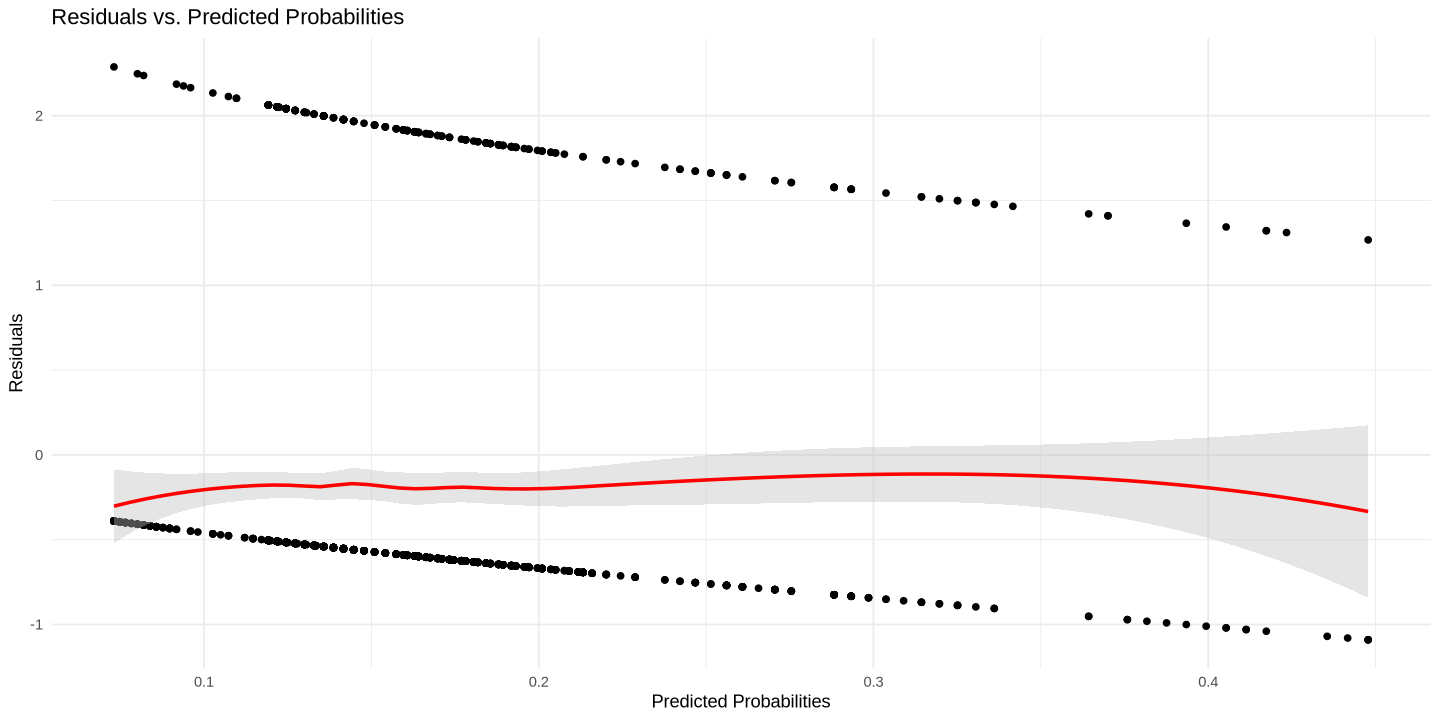

In [44]:
# CHECKING INDEPENDENCE

options(repr.plot.width=12, repr.plot.height=6)
options(warn=-1)

# A. Get predicted probabilities and residuals
HR_predicted <- HR_clean %>%
  mutate(
    predicted_prob = predict(logit_model, type = "response"),
    residuals = residuals(logit_model, type = "deviance"),    
    standardized_residuals = residuals / sqrt(predicted_prob * (1 - predicted_prob)))

# B. Plot residuals vs. predicted probabilities
cat("Figure 7. Residuals Vs. Predicted Probabilities - Independence Assumption Assessment\n\n")
ggplot(HR_predicted, aes(x = predicted_prob, y = residuals)) +
  geom_point() +
  geom_smooth(method = "loess", color = "red", fill = "grey") +
  labs(title = "Residuals vs. Predicted Probabilities",
       x = "Predicted Probabilities",
       y = "Residuals") +
  theme_minimal()

### Observations: 
The residuals vs. predicted probabilities plot shows a downward trend, indicating a potential violation of the independence assumption. This can lead to biased estimates and unreliable inferences.

#### 3. No Collinearity (or Multicollinearity): Satisfied

In [24]:
# CHECKING FOR COLLINEARITY WITH VIF

vif_values <- vif(logit_model)
vif_values

,GVIF,Df,GVIF^(1/(2*Df))
DistanceFromHome,1.001166,1,1.000583
JobInvolvement,1.001166,3,1.000194


#### Observations 
GVIF values are well below the threshold of 5.

#### 4. Linearity: Reasonably Satisfied

Figure 8. Standardized Residuals Vs. DistanceFromHome



`geom_smooth()` using formula = 'y ~ x'


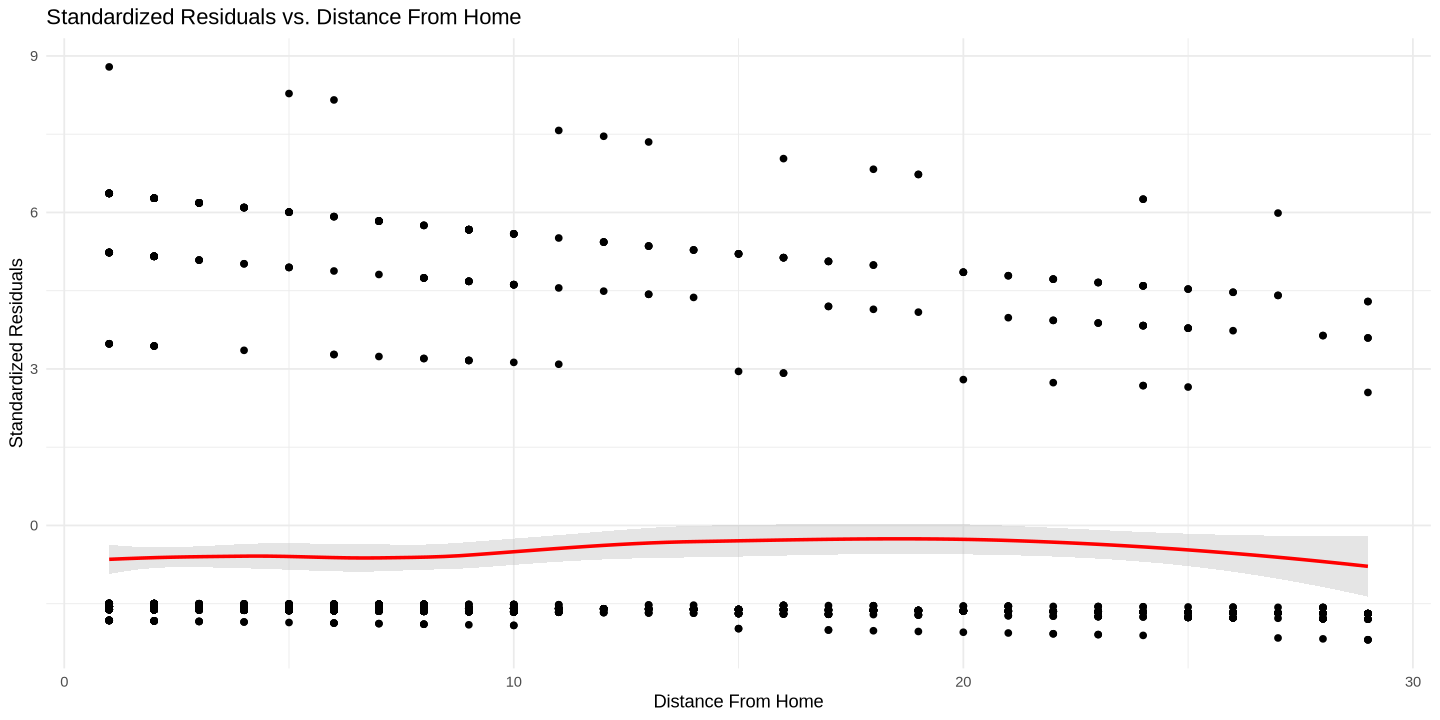

In [45]:
#CHECKING FOR LINEARITY

options(repr.plot.width=12, repr.plot.height=6)

# A. Plot Standardized Residuals vs. DistanceFromHome
cat("Figure 8. Standardized Residuals Vs. DistanceFromHome\n\n")
ggplot(HR_predicted, aes(x = DistanceFromHome, y = standardized_residuals)) +
  geom_point() +
  geom_smooth(method = "loess", color = "red", fill = "grey") +
  labs(title = "Standardized Residuals vs. Distance From Home",
       x = "Distance From Home",
       y = "Standardized Residuals") +
  theme_minimal()

#### Observations
- There is some non-linearity in the relationship between DistanceFromHome and the standardized residuals as the loess curves are not completely flat. Though the non-linearity is not severe, we will consider a polynomial transformation of DistanceFromHome in our regression model.

In [46]:
# transforming distancefromhome

transf_model <- glm(Attrition~JobInvolvement+poly(DistanceFromHome, 2), data=HR_clean, family="binomial") 
transf_results <-  tidy(transf_model, exponentiate= TRUE) %>%
   mutate_if(is.numeric, round, 3) 

cat("Figure 9 Logistic Regression Model Results - Transformed DistanceFromHome Summary\n\n")
transf_model

Figure 9 Logistic Regression Model Results - Transformed DistanceFromHome Summary




Call:  glm(formula = Attrition ~ JobInvolvement + poly(DistanceFromHome, 
    2), family = "binomial", data = HR_clean)

Coefficients:
               (Intercept)             JobInvolvement2  
                   -0.6845                     -0.7675  
           JobInvolvement3             JobInvolvement4  
                   -1.1238                     -1.6626  
poly(DistanceFromHome, 2)1  poly(DistanceFromHome, 2)2  
                    8.1366                     -4.0702  

Degrees of Freedom: 1469 Total (i.e. Null);  1464 Residual
Null Deviance:	    1299 
Residual Deviance: 1262 	AIC: 1274

#### Observations
- All of the coefficients are significant, but there is no change in the estimate, standard error, statistic and p-value for this predictor. We thus continue to produce the diagnostic plots to see any potential alterations below.

Figure 10 Standardized Residuals Vs. Transformed DistanceFromHome



`geom_smooth()` using formula = 'y ~ x'


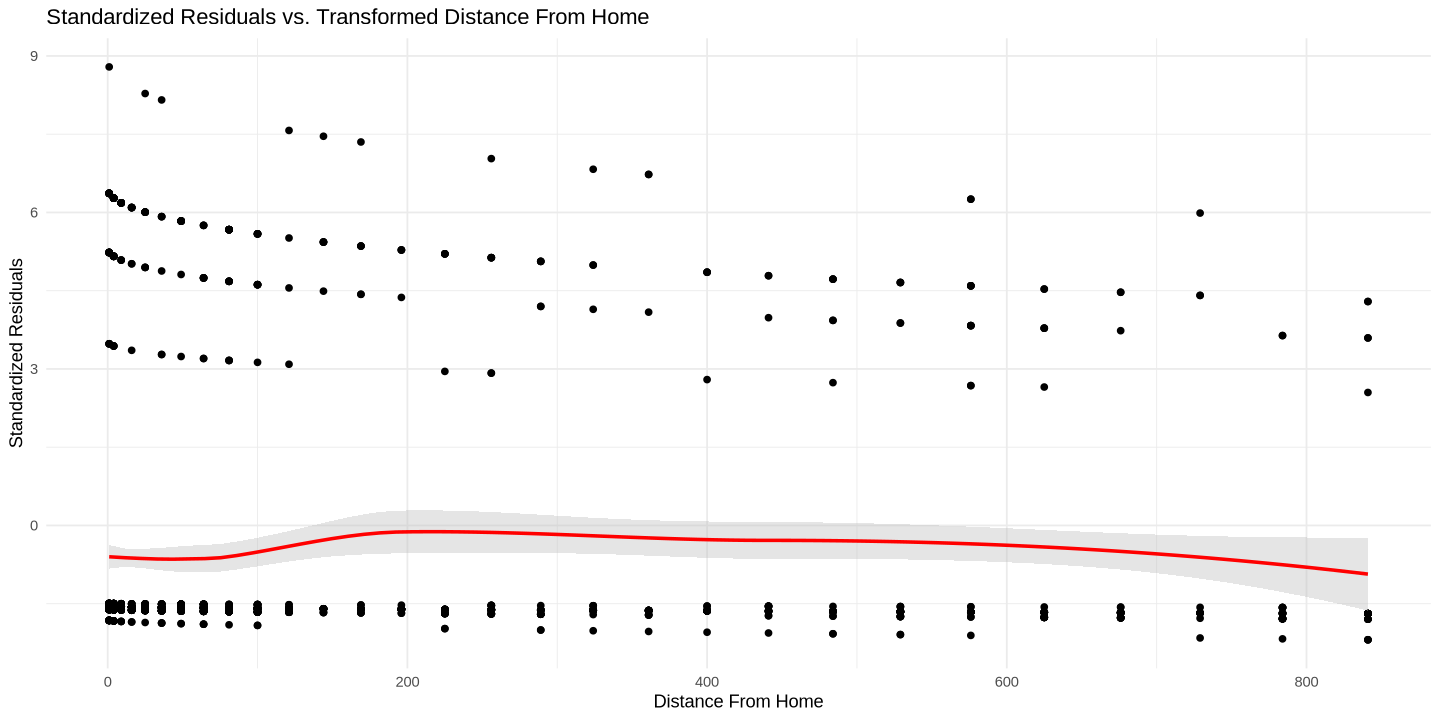

In [47]:
#CHECKING FOR LINEARITY

options(repr.plot.width=12, repr.plot.height=6)

# A. Plot Standardized Residuals vs. DistanceFromHome
cat("Figure 10 Standardized Residuals Vs. Transformed DistanceFromHome\n\n")
ggplot(HR_predicted, aes(x = DistanceFromHome^2, y = standardized_residuals)) +
  geom_point() +
  geom_smooth(method = "loess", color = "red", fill = "grey") +
  labs(title = "Standardized Residuals vs. Transformed Distance From Home",
       x = "Distance From Home",
       y = "Standardized Residuals") +
  theme_minimal()

#### Observations
Transforming the `DistanceFromHome` predictor did not significantly improve the model's performance. The plot shows a clearer pattern between the standardized residuals and the `DistanceFromHome` predictor than the original model. Therefore, we continue our study with the original logistic model without polynomial terms.

### 5. No Outliers in the Continuous Predictor Variable(s): Satisfied 

Figure 11. Cooks Distance Plot of Observations



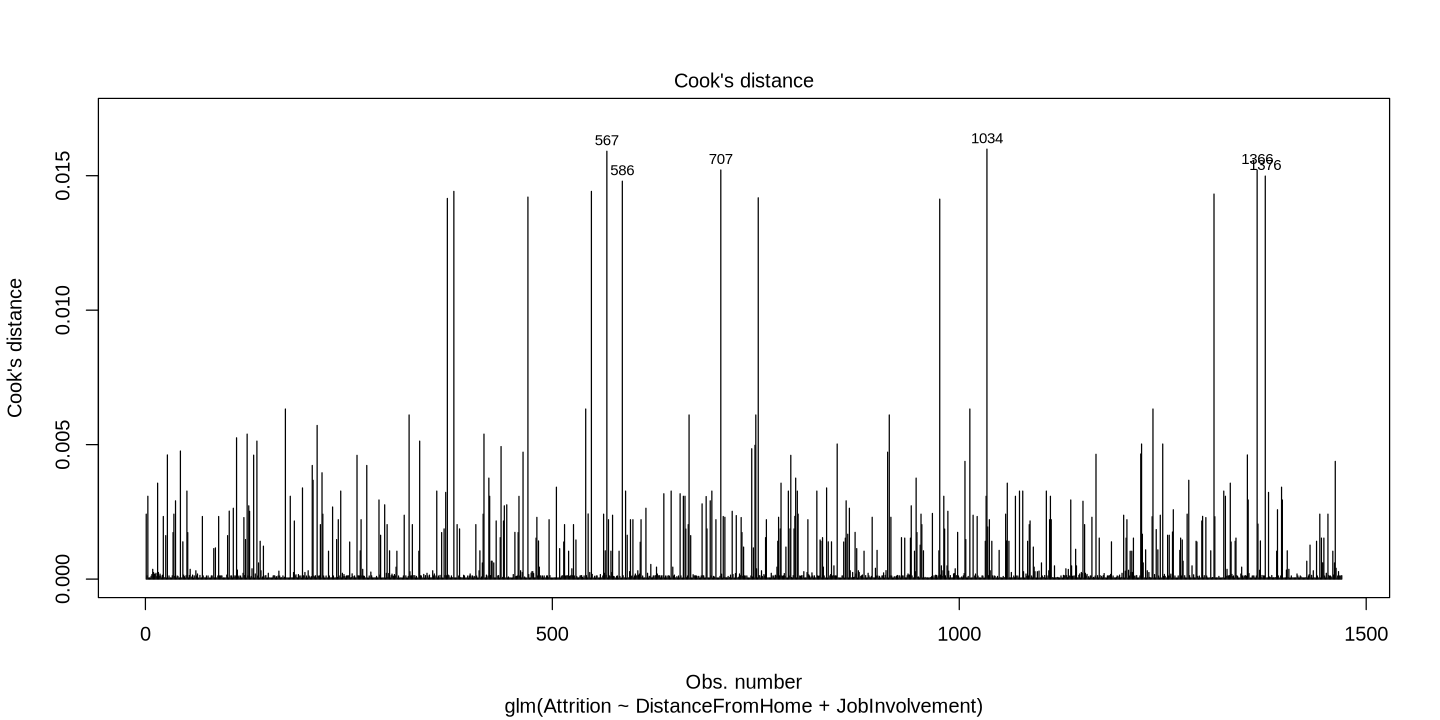

In [49]:
#CHECKING FOR OUTLIERS

plot(logit_model, which = 4, id.n = 6)
cat("Figure 11. Cooks Distance Plot of Observations\n\n")

#### Observations
- Cook's distance values are all below 0.03 (and the threshold of 1), indicating no highly influential outliers. For additional evaluation of outliers we assess the impact of removing observations greater than 4/𝑛, where n is the number of observations. 

In [50]:
# Removing Influential Points

# IDENTIFYING INFLUENTIAL POINTS BY THRESHOLD: 4/N
threshold <- 4 / nrow(HR_clean)
influential_points <- which(cooks.distance(logit_model) > threshold)
length(influential_points)

[1] 104

In [51]:
# REMOVING THESE POINTS FROM THE DATAFRAME

removed_data <- HR_clean[-influential_points,]
nrow(removed_data)

[1] 1366

In [52]:
# Now, we fit the model again, having removed these influential points (now sample size is 1366, compared to 1470).
removed_logit <- glm(Attrition~DistanceFromHome+JobInvolvement, data=removed_data, family="binomial")

options(warn = -1)

removed_logit_results <- removed_logit %>%
    tidy(exponentiate=TRUE, conf.int=TRUE) %>%
    mutate_if(is.numeric, round, 3)

cat("Figure 12. Logistic Regression Model Results - Removed Influential Points\n\n")
removed_logit_results

Figure 12. Logistic Regression Model Results - Removed Influential Points



term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.000,922.194,-0.020,0.984,0.000000e+00,3.055343e+08
DistanceFromHome,0.993,0.012,-0.620,0.535,9.690000e-01,1.016000e+00
JobInvolvement2,10702979.093,922.194,0.018,0.986,1.699041e+18,2.896833e+165
JobInvolvement3,17262313.330,922.194,0.018,0.986,0.000000e+00,2.947603e+142
JobInvolvement4,1.009,1083.983,0.000,1.000,0.000000e+00,2.221688e+07


#### Observations
The p-values for all the coefficients have changed to being non-significant, indicating that removing points with this threshold may not be the most reliable option from a statistical performance point of view.

### <span style="background-color: lightgreen"> 6. Interpreting the Model

In [53]:
cat("Figure 13. Logistic Regression Model Results Summary\n\n")
logit_results

Figure 13. Logistic Regression Model Results Summary



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.395,0.250,-3.722,0.000
DistanceFromHome,1.025,0.008,2.964,0.003
JobInvolvement2,0.469,0.268,-2.822,0.005
JobInvolvement3,0.334,0.253,-4.335,0.000
JobInvolvement4,0.195,0.373,-4.384,0.000


### Coefficients Interpretation
- $Intercept$: The baseline odds of attrition for employees with low job involvement and living zero kilometers from the office are approximately 0.395. This means for every 1 employee who leaves, about 2.53 employees stay (
1/0.395≈2.53).
- DistanceFromHome: Each additional km between an employee's home and the office increases the odds of attrition by approximately 2.5%, holding job involvement constant.
- $JobInvolvement_2$: Holding distance from home constant, employees with medium job involvement have odds of attrition approximately 0.469 times those of low job involvement, or there is a 53.1% reduction in odds to leave (
1−0.469≈0.531).
- $JobInvolvement_3$: Holding distance from home constant, employees with high job involvement have odds of attrition approximately 0.334 times those of low job involvement, or there is a 66.6% reduction in odds to leave (
1−0.334≈0.666).
- $JobInvolvement_4$: Holding distance from home constant, employees with very high job involvement have odds of attrition approximately 0.195 times those of low job involvement, or there is a 80.5% reduction in odds to leave (
1−0.195≈0.805).

### <span style="background-color: lightgreen"> 7. Model Inference

To investigate the association between Attrition and DistanceFromHome, and JobInvolvement, we perform hypothesis testing and evaluate the confidence intervals. Firstly, the hypothesis test performed for this study is as follows: 
\begin{gather*}
H_0: \beta_j = 0\\
H_a: \beta_j \neq 0.
\end{gather*}
where $j=1,2,3,4$. 

The wald’s statistic is: $$z_j = \frac{\hat{\beta}_j}{\mbox{SE}\left(\hat{\beta}_j\right)}$$
- Under $H_0$ it approximately follows a standard normal distribution. Given the large sample size (1366 observations), this assumption is satisfied by the properties of maximum likelihood estimation and the Central Limit Theorem.

We perform hypothesis testing and interpret the p-values to determine the significance of each predictor variable in relation to the odds of Attrition.

In [54]:
logit_infer_results <- 
   logit_model %>%
   tidy(exponentiate = TRUE, conf.int=TRUE)  %>%
   mutate_if(is.numeric, round, 3)

cat("Figure 14. Logistic Regression Model Results - 95% Confidence Interval\n\n")
logit_infer_results

Figure 14. Logistic Regression Model Results - 95% Confidence Interval



term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.395,0.250,-3.722,0.000,0.239,0.638
DistanceFromHome,1.025,0.008,2.964,0.003,1.008,1.042
JobInvolvement2,0.469,0.268,-2.822,0.005,0.278,0.800
JobInvolvement3,0.334,0.253,-4.335,0.000,0.205,0.554
JobInvolvement4,0.195,0.373,-4.384,0.000,0.091,0.397


### Observed Results
With a large sample size, the confidence intervals provide stable and reliable estimates. Based on the results in Table X, we gather the following insights on the relationship between distance from home and job involvement on attrition.

#### Coefficient Significance ($\alpha = 0.05$)
- $Intercept$: We reject $H_0$ (p ≈ 0). We have sufficient evidence to suggest that the baseline odds of attrition for employees with low job involvement living zero kilometers from the office are significant.
- $DistanceFromHome$: With a p-value=0.003, we reject H0. We have sufficient evidence to conclude that distance from home is associated with the odds of attrition.
- $JobInvolvement_2$ The p-value = 0.005 leads us to reject H0. We have sufficient evidence to conclude that medium job involvement is a significant predictor of attrition.
- $JobInvolvement_3$ With a p-value~=0, we reject H0. We have sufficient evidence to conclude that high job involvement is a significant predictor of attrition.
- $JobInvolvement_4$ The p-value~=0 leads us to reject H0. We have sufficient evidence to conclude that very high job involvement is significantly associated with the odds of attrition

#### 95% Confidence Intervals
- $Intercept$: [0.239,0.638] We are 95% confident that the true odds of attrition for employees with  low job involvement level living zero kilometers from the office lie between 0.239 and 0.638. This range being < 1 suggests lower odds of attrition for the baseline group.
- $DistanceFromHome$: [1.008,1.042] We are 95% confident that the true odds ratio for distance from home lies between 1.008 and 1.042. This range being > 1 indicates a positive association between distance from home and the odds of attrition.
- $JobInvolvement_2$: [0.278,0.800] We are 95% confident that the true odds ratio for medium job involvement lies between 0.278 and 0.800. This interval being < 1 indicates lower odds of attrition compared to low job involvement.
- $JobInvolvement_3$: [0.205,0.554] We are 95% confident that the true odds ratio for high job involvement lies between 0.205 and 0.554. This range being < 1 indicates lower odds of attrition compared to low job involvement.
- $JobInvolvement_4$: [0.091,0.397] We are 95% confident that the true odds ratio for very high job involvement lies between 0.091 and 0.397. This range being < 1 indicates lower odds of attrition compared to low job involvement level.

### <span style="background-color: lightgreen"> 8. Model Assessment

To evaluate how well our logistic regression model fits this dataset, we will first look at the AIC and BIC metrics between the null and final model.

In [55]:
null_model <- glm(Attrition~1, data=HR_clean,family="binomial")
cat("Figure 15. AIC Comparison for Null and Final Model\n\n")
AIC(null_model, logit_model)

Figure 15. AIC Comparison for Null and Final Model



,df,AIC
,<dbl>,<dbl>
null_model,1,1300.583
logit_model,5,1274.364


In [56]:
cat("Figure 16. BIC Comparison for Null and Final Model\n\n")
BIC(null_model, logit_model)

Figure 16. BIC Comparison for Null and Final Model



,df,BIC
,<dbl>,<dbl>
null_model,1,1305.876
logit_model,5,1300.829


#### Observations
The lower AIC and BIC values compared to the null model indicate that adding DistanceFromHome and JobInvolvement improves the model's fit. These metrics balance goodness of fit and model complexity, with BIC penalizing more for the number of parameters. The lower AIC and BIC values, along with significant p-values, suggest that DistanceFromHome and JobInvolvement significantly contribute to explaining attrition.

# <span style="background-color: yellow"> III. Discussion

### Results and Implications
In line with our hypothesis and Zhang et al. (2023), we find that there is a significant positive correlation between the distance from home to the workplace and the probability of attrition (p = .003 < .05). The farther employees live from their workplace, the more likely they are to leave. Similar to Haivas et al. (2013), we found that the effect of Job Involvement on the odds of attrition depends on the level of involvement. Employees with medium/high/very high job involvement are significantly less likely to leave their jobs compared to those with a low job involvement level (the reference level).

Understanding these relationships have important implications for company management to reduce the likelihood of attrition: 
Distance from home: Companies can introduce support or consider options such as hybrid or remote work for employees who have long commutes.
Job involvement: Companies can boost job involvement by improving job autonomy and competence (Olafsen et al., 2017), such as offering career development opportunities, and giving employees more freedom in their routine.

As for our model fit, our AIC and BIC metrics suggest that models including DistanceFromHome and JobInvolvement variables fit the data better compared to null models that only include intercepts. 
Lower AIC and BIC values indicate that these models are less complex and provide a better fit for the data.


### Areas for Model Improvement
1. **Improving Data Independence:** Our analysis assessed the independence assumption of the model, revealing a downward trend in the plot of residuals versus predicted probabilities. This trend could bias the standard error estimates and potentially invalidate our confidence intervals and hypothesis tests. 

2. **Data Splitting for Model Validation:** Data splitting was not employed in our study. Implementing data splitting can help prevent overfitting, reduce inflated significance, avoid biased estimates, and improve the generalizability of findings.
   - Thus, while our findings suggest significant links between employee distance from home, job involvement, and attrition, the absence of data splitting necessitates cautious interpretation. Our results may be influenced by dataset-specific characteristics and might not reflect broader trends.
   
### Future Research Directions
We believe it would be beneficial for future research to incorporate psychological factors into our logistic model, such as employee job stress, perceived work-life balance, and marital status to gain a more comprehensive understanding of employee attrition.

# <span style="background-color: yellow"> IV. References

Bakker, A. B., & Demerouti, E. (2007). The job demands‐resources model: State of the art. *Journal of Managerial Psychology, 22*(3), 309–328. https://doi.org/10.1108/02683940710733115

Haivas, S., Hofmans, J., & Pepermans, R. (2013). Volunteer engagement and intention to quit from a self‐determination theory perspective. *Journal of Applied Social Psychology, 43*(9), 1869–1880. https://doi.org/10.1111/jasp.12149

Olafsen, A. H. (2016). The implications of need-satisfying work climates on state mindfulness in a longitudinal analysis of work outcomes. *Motivation and Emotion, 41*(1), 22–37. https://doi.org/10.1007/s11031-016-9592-4

Zhang, X., Li, Q., & Wang, Y. (2023). Impact of commuting time on employees’ job satisfaction—an empirical study based on China’s Family Panel Studies (CFPS). *Sustainability, 15*(19), 14102. https://doi.org/10.3390/su151914102
